# Randomization Unit

This notebook will check the issues of randomizing by user but evaluating by sessions

In [3]:
from __future__ import annotations
from IPython import get_ipython
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

import scipy.stats as stats
from sklearn.metrics import auc
from scipy.stats import chisquare

In [4]:
def assign_random_variant(df, users, variant_col, random_seed=42, num_samples=None, replace=True):
    np.random.seed(random_seed)
    unique_users = pd.DataFrame({"user_id":users, 
                                 variant_col:np.random.choice(['control', 'treatment'], size=len(users), p=[0.5, 0.5])})
    if num_samples:
        unique_users = unique_users.sample(num_samples, replace=replace)
    df = df.merge(unique_users, how="left", on="user_id")
    return df

In [5]:
def t_test_mean_diff(df, variant_col, value_col, variant1="treatment", variant2="control", 
                     alpha=0.05, alternative='two-sided'):
    control_values = df[df[variant_col] == variant1][value_col]
    treatment_values = df[df[variant_col] == variant2][value_col]
    t_statistic, p_value = stats.ttest_ind(control_values, treatment_values, alternative=alternative)
    
    # Determine whether to reject the null hypothesis
    reject_null = p_value < alpha
    
    return t_statistic, p_value, reject_null

# Define the function to apply the z-test to multiple dataframes
def run_test_mean_diff(df, variant_col, value_col, number_of_tests=100, 
                                num_samples=None, alternative="two-sided", effect=0, alpha=0.05):
    # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=['test_number', 
                                       't_score', 'p_value', 'reject_null'])
    if variant_col in df.columns:
        df.drop(variant_col, inplace=True, axis=1)
    
    users = df["user_id"].unique()
    
    # Iterate over pairs of dataframes
    for i in range(number_of_tests):
        if i % 25 == 0:
            print(i)
        random_df = assign_random_variant(df, users=users, variant_col=variant_col, random_seed=i, num_samples=num_samples)
        random_df[value_col] = np.where(random_df[variant_col]=="treatment", 
                                        random_df[value_col]*(1+effect), 
                                        random_df[value_col])

        # Apply the t-test to the pair of dataframes
        t_score, t_p_value, t_reject_null = t_test_mean_diff(random_df, variant_col=variant_col, alpha=alpha,
                                                             value_col=value_col, alternative=alternative)
        
        # Add the results to the DataFrame
        this_results = pd.DataFrame({'test_number': i,
                                        't_score': t_score,
                                        'p_value': t_p_value,
                                        'reject_null': t_reject_null, },
                                   index=[0])
        results_df = pd.concat([results_df, this_results])
    
    # Return the results DataFrame
    return results_df

In [6]:
base_path = os.path.abspath('')

events_df = pd.read_csv(f"{base_path}/Data/events_complete.csv")
events_df = events_df[(events_df["date"]).between("2020-01-01", "2020-02-31")]

events_df.replace({True: 1, False: 0}, inplace=True)
events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
12271406,2020-01-01 00:00:00 UTC,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,2020-01-01 00:00:00+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0
12271407,2020-01-01 00:00:09 UTC,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,2020-01-01 00:00:09+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0
12271408,2020-01-01 00:00:19 UTC,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,2020-01-01 00:00:19+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0
12271409,2020-01-01 00:00:24 UTC,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711,2020-01-01 00:00:24+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0
12271410,2020-01-01 00:00:25 UTC,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,2020-01-01 00:00:25+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0


Plot the distributions of events/sessions per user and the convertions (has_purchase) vs that

In [59]:
agg_ussers = (
    events_df
    .groupby("user_id")
    .agg({
        "product_id":           "count",
        "user_session":         "nunique",
        "event_type_purchase":  "sum",
        "sales":                "sum",
    })
).reset_index()

agg_ussers.columns = ["user_id", "events", "sessions", "n_purchases", "total_sales"]
agg_ussers

,user_id,events,sessions,n_purchases,total_sales
0,465496,3,2,0.0,0.0
1,2038666,1,1,0.0,0.0
2,3571443,2,1,0.0,0.0
3,4230352,1,1,0.0,0.0
4,4661182,20,6,0.0,0.0
...,...,...,...,...,...
737088,622090016,2,2,0.0,0.0
737089,622090043,3,1,0.0,0.0
737090,622090052,2,2,0.0,0.0
737091,622090098,1,1,0.0,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


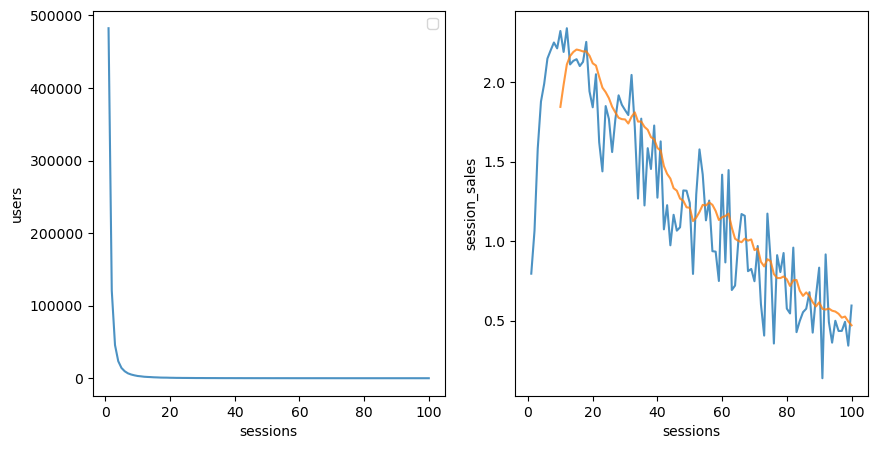

In [60]:
sessions_per_user = (
    agg_ussers
    .groupby("sessions")
    .agg({
        "user_id":      "count",
        "n_purchases":  "sum",
        "total_sales":  "sum",
    })
).reset_index()
sessions_per_user.columns = ["sessions", "users", "n_purchases", "total_sales"]
sessions_per_user["purchases_per_user"] = sessions_per_user["n_purchases"] / sessions_per_user["users"]
sessions_per_user["session_conversions"] = sessions_per_user["purchases_per_user"] / sessions_per_user["sessions"]
sessions_per_user['session_conversions_ma'] = sessions_per_user['session_conversions'].rolling(10).mean()

sessions_per_user["sales_per_user"] = sessions_per_user["total_sales"] / sessions_per_user["users"]
sessions_per_user["session_sales"] = sessions_per_user["sales_per_user"] / sessions_per_user["sessions"]
sessions_per_user['session_sales_ma'] = sessions_per_user['session_sales'].rolling(10).mean()

fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.lineplot(sessions_per_user[sessions_per_user["sessions"].between(1,100)], x="sessions", y="users", ax=ax[0], alpha=0.8)
sns.lineplot(sessions_per_user[sessions_per_user["sessions"].between(1,100)], x="sessions", y="session_sales", ax=ax[1], alpha=0.8)
sns.lineplot(sessions_per_user[sessions_per_user["sessions"].between(1,100)], x="sessions", y="session_sales_ma", ax=ax[1], alpha=0.8)

ax[0].legend()

## p-values

In [26]:
# Transform to user-based data
sessions_df = events_df.groupby(["user_session", "user_id"]).agg(
    {
        "user_id":                      ['size'],
        "sales":                        ['sum'],
        "event_type_view":              ["sum", "max"],
        "event_type_cart":              ["sum", "max"],
        "event_type_remove_from_cart":  ["sum", "max"],
        "event_type_purchase":          ["sum", "max"],
        "date":                         ["min", "max"]
    }
)
sessions_df.columns = ['_'.join(col).strip() for col in sessions_df.columns.values]
sessions_df = sessions_df.rename(columns={
    'user_id_size': 'num_events', 'sales_sum': 'total_sales', 
    'event_type_view_sum': 'total_views', 'event_type_view_max': 'has_view',
    'event_type_cart_sum': 'total_cart', 'event_type_cart_max': 'has_cart',
    'event_type_remove_from_cart_sum': 'total_remove_from_cart', 'event_type_remove_from_cart_max': 'has_remove_from_cart',
    'event_type_purchase_sum': 'total_purchases', 'event_type_purchase_max': 'has_purchases',
}).reset_index()
sessions_df = assign_random_variant(sessions_df, variant_col="variant")


In [57]:
iterations = 500
samples = 2000

p_values_AA = run_test_mean_diff(sessions_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=iterations, num_samples=samples, alternative="greater")
p_values_AA = p_values_AA.reset_index(drop=True)
p_values_AA.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


,test_number,t_score,p_value,reject_null
0,0,0.446301,0.327699,False
1,1,1.088579,0.138197,False
2,2,-1.151888,0.875289,False
3,3,0.484230,0.314122,False
4,4,-1.729393,0.958099,False


auc p-value: 0.5840730941922826


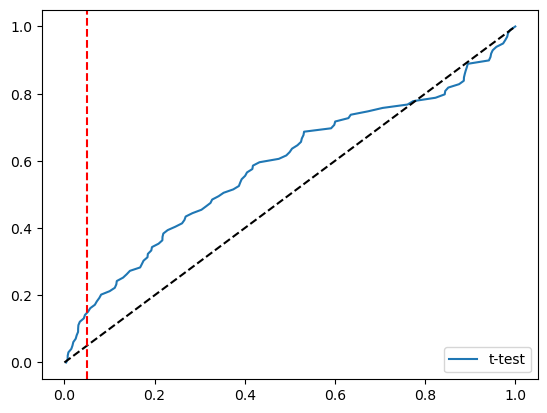

In [61]:
auc_value = auc(sorted(p_values_AA["p_value"]), np.linspace(0, 1, iterations))
print(f"auc p-value: {auc_value}")

fig, ax = plt.subplots()
ax.plot(sorted(p_values_AA["p_value"]), np.linspace(0, 1, iterations), label="t-test")
ax.legend()
ax.plot([0,1],[0,1], '--k')
ax.axvline(0.05, ls='--', color="red")

We can observe that the p-values are not uniformely distributed under the null, with ~15% false positives expected if we use the sessions